### EOFs-LSTM

In [1]:
#  ------------------ import necessary packages
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#  ------------------ load training and test sets 
path_to_X_train = 'X_train.npy'
path_to_X_test = 'X_valid.npy'

path_to_Y_train = 'Y_train.npy'
path_to_Y_test = 'Y_valid.npy'

d_X_train = np.load(path_to_X_train, allow_pickle=True)
d_X_test = np.load(path_to_X_test, allow_pickle=True)

d_Y_train = np.load(path_to_Y_train, allow_pickle=True)
d_Y_test = np.load(path_to_Y_test, allow_pickle=True)

In [3]:
print(d_X_train.shape)
print(d_X_test.shape)

print(d_Y_train.shape)
print(d_Y_test.shape)

(2700, 64, 96, 12)
(300, 64, 96, 12)
(2700, 12)
(300, 12)


In [4]:
d_X_train = np.transpose(d_X_train, (0,3,1,2))
d_X_train.shape

d_X_test = np.transpose(d_X_test, (0,3,1,2))
d_X_test.shape

(300, 12, 64, 96)

In [5]:
X_train_reshape = np.reshape(d_X_train, (2700*12, 64*96))
print(X_train_reshape.shape)

X_train_smaller = X_train_reshape[:,:]
Y_train_smaller = d_Y_train[:,1]
print(X_train_smaller.shape)
print(Y_train_smaller.shape)

print('')

X_test_reshape = np.reshape(d_X_test, (300*12,6144))
print(X_test_reshape.shape)

X_test_smaller = X_test_reshape[:,:]
Y_test_smaller = d_Y_test[:,1]
print(X_test_smaller.shape)
print(Y_test_smaller.shape)

(32400, 6144)
(32400, 6144)
(2700,)

(3600, 6144)
(3600, 6144)
(300,)


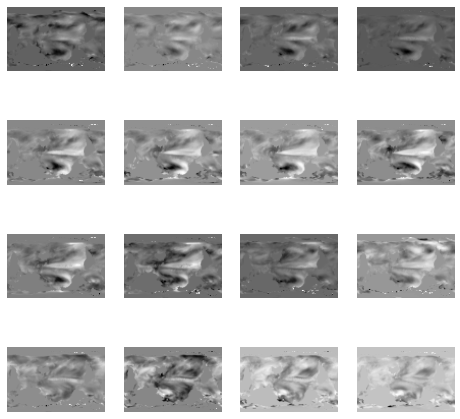

In [6]:
def plot_grid(XX, N):  #def plot_digits(XX, N, title): 
    """Small helper function to plot N**2 digits."""
    fig, ax = plt.subplots(N, N, figsize=(8, 8))
    for i in range(N):
        for j in range(N):
            ax[i,j].imshow(XX[(N)*i+j,:].reshape((64, 96)), cmap="Greys")
            ax[i,j].axis("off")
            # fig.suptitle(title, fontsize=24)

# plot_digits(X_train, 8, "First 64 Training Features" )
plot_grid(X_train_smaller, 4)

In [7]:
# using sklearn

# --- 
# Pointer: sklearn has functionalities for PCA and Ridge regression with crossvalidation. 
# Using these can make your life much easier.
# --- 

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [8]:
X_train = X_train_smaller
X_test = X_test_smaller

Y_train = Y_train_smaller
Y_test = Y_test_smaller

In [9]:
mean_data = np.mean(X_train,0)
centered_X_train = X_train - mean_data

# X_train_standard = StandardScaler().fit_transform(centered_X_train)

pca = PCA(n_components = 100)
pca.fit(centered_X_train) #X_train_standard

components = pca.components_
print(components[:16,:].shape)

(16, 6144)


In [102]:
mean_data = np.mean(X_test,0)
centered_X_test = X_test - mean_data

# X_train_standard = StandardScaler().fit_transform(centered_X_train)

pca_test = PCA(n_components = 100)
pca_test.fit(centered_X_test) #X_train_standard

components_test = pca.components_
print(components_test[:16,:].shape)

(16, 6144)


##### Use PCA to investigate the dimensionality of X_train and plot the first 16 modes

In [10]:
#### Explained variance, explained variance ratio, singular values
# -------------------------------------------
# From documentation:

# explained_variance_ : array, shape (n_components,) The amount 
# of variance explained by each of the selected components.

# explained_variance_ratio_ : array, shape (n_components,) Percentage 
# of variance explained by each of the selected components.

# singular_values_ndarray of shape (n_components,)
# The singular values corresponding to each of the selected components. 
# The singular values are equal to the 2-norms of the n_components 
# variables in the lower-dimensional space.

# -------------------------------------------

nuclear_norm = np.linalg.norm(pca.singular_values_) # is the sum of singular singulars
sv_scaled = pca.singular_values_**2/(nuclear_norm**2) 
# sv_scaled = pca.explained_variance_ratio_
sv_total = np.cumsum(pca.singular_values_**2)/(nuclear_norm**2)

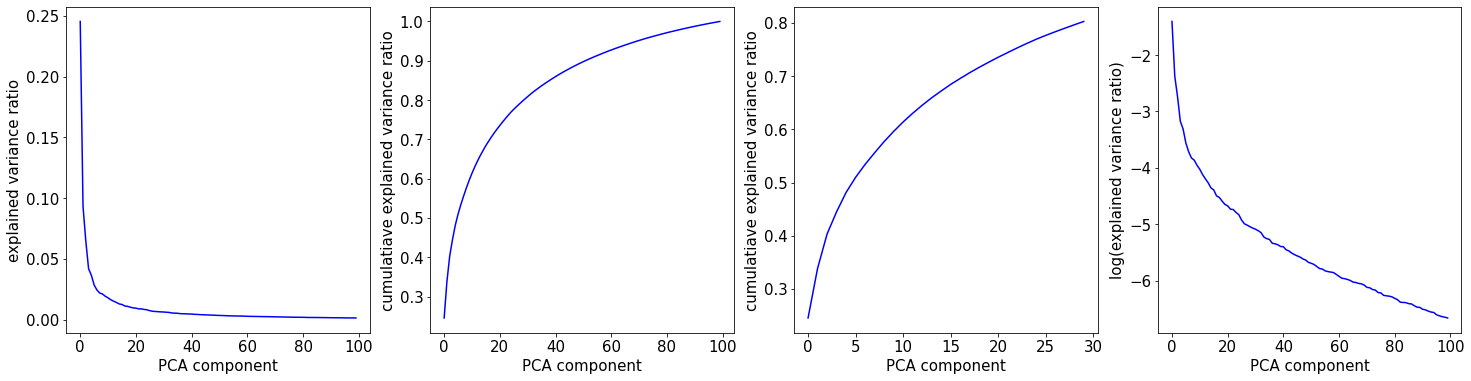

In [11]:
# -- Plot the singular values
plt.rcParams["figure.figsize"] = (25,6)

plt.subplot(1, 4, 1)
plt.plot(sv_scaled, 'blue') # equivalent to pca.explained_variance_ratio_
plt.xticks(fontsize=15); plt.yticks(fontsize=15)
plt.xlabel('PCA component', fontsize=15)
plt.ylabel('explained variance ratio', fontsize=15)

plt.subplot(1, 4, 2)
plt.plot(sv_total, 'blue')
plt.xticks(fontsize=15); plt.yticks(fontsize=15)

plt.xlabel('PCA component', fontsize=15)
plt.ylabel('cumulatiave explained variance ratio', fontsize=15)

plt.subplot(1, 4, 3)
plt.plot(sv_total[:30], 'blue')
plt.xticks(fontsize=15); plt.yticks(fontsize=15)

plt.xlabel('PCA component', fontsize=15)
plt.ylabel('cumulatiave explained variance ratio', fontsize=15)

plt.subplot(1, 4, 4)
plt.plot(np.log(sv_scaled),'blue') # equivalent to np.log(pca.singular_values_)
# plt.plot(np.log(pca.singular_values_))
plt.xticks(fontsize=15); plt.yticks(fontsize=15)
plt.xlabel('PCA component', fontsize=15)
plt.ylabel('log(explained variance ratio)', fontsize=15)

plt.show()

##### How many PCA modes do you need to keep in order to approximate X_train up to 60%, 80% and 90% in the Frobenius norm?

In [12]:
pca_total = PCA(n_components=100)
pca_total.fit(X_train)
frobenius_norm = np.sqrt(sum(pca_total.singular_values_**2))

In [13]:
def no_pca_modes(ratio):
    pca_test = PCA(n_components=1)
    pca_test.fit(X_train)
    np.sqrt(sum(pca_test.singular_values_**2))
    i = 1
    while np.sqrt(sum(pca_test.singular_values_**2)) < ratio*frobenius_norm:
        i += 1
        pca_test = PCA(n_components=i)
        pca_test.fit(X_train)
    return i

print('Number of PCA modes to keep to approximate X_train up to 60%: ', no_pca_modes(0.6))
print('Number of PCA modes to keep to approximate X_train up to 80%: ',no_pca_modes(0.8))
print('Number of PCA modes to keep to approximate X_train up to 90%: ',no_pca_modes(0.9))

Number of PCA modes to keep to approximate X_train up to 60%:  3
Number of PCA modes to keep to approximate X_train up to 80%:  13
Number of PCA modes to keep to approximate X_train up to 90%:  32


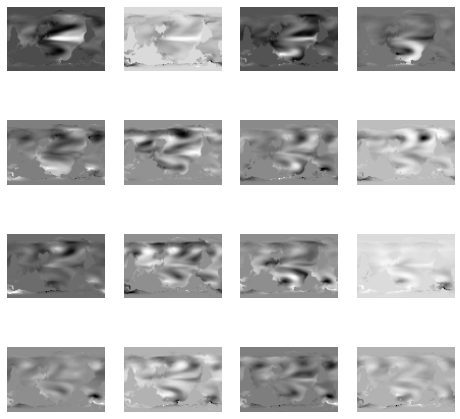

In [14]:
plot_grid(components[:16,:], 4)

In [15]:
print(X_train.shape)

(32400, 6144)


For any one SST snapshot, we should be able to find coefficient

In [19]:
PCs = pca.transform(X_train)

In [22]:
print(PCs[:,0:13].shape)

(32400, 13)


In [25]:
PCs_reshape = np.reshape(PCs[:,0:13], (2700,12,13))

In [26]:
print(PCs_reshape.shape)

(2700, 12, 13)


In [104]:
PCs_test = pca.transform(X_test)
print(PCs_test[:,0:13].shape)
PCs_test_reshape = np.reshape(PCs_test[:,0:13], (300,12,13))
print(PCs_test_reshape.shape)

(3600, 13)
(300, 12, 13)


### LSTM

In [28]:
# import deep learning libraries
import tensorflow as tf
from tensorflow import keras

In [30]:
inputs = PCs_reshape
lstm = tf.keras.layers.LSTM(4)

In [32]:
output = lstm(inputs)

In [33]:
output.shape

TensorShape([2700, 4])

In [89]:
x = tf.keras.layers.Input((12,13))
y = tf.keras.layers.LSTM(100, return_sequences=True)(x)
y = tf.keras.layers.LSTM(100, return_sequences=False)(y)
y = tf.keras.layers.Dense(12, activation='linear')(y)

In [90]:
model = tf.keras.models.Model(x,y)
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 12, 13)]          0         
                                                                 
 lstm_25 (LSTM)              (None, 12, 100)           45600     
                                                                 
 lstm_26 (LSTM)              (None, 100)               80400     
                                                                 
 dense_1 (Dense)             (None, 12)                1212      
                                                                 
Total params: 127,212
Trainable params: 127,212
Non-trainable params: 0
_________________________________________________________________


In [91]:
# https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile
model.compile(optimizer='adam', loss='MSE', metrics=['MSE'])

In [92]:
hist = model.fit(x = PCs_reshape, y = d_Y_train, epochs=20)

Epoch 1/20
85/85 [==============================] - 8s 58ms/step - loss: 0.9379 - MSE: 0.9379
Epoch 2/20
85/85 [==============================] - 5s 58ms/step - loss: 0.5692 - MSE: 0.5692
Epoch 3/20
85/85 [==============================] - 5s 57ms/step - loss: 0.4249 - MSE: 0.4249
Epoch 4/20
85/85 [==============================] - 5s 63ms/step - loss: 0.3190 - MSE: 0.3190
Epoch 5/20
85/85 [==============================] - 5s 57ms/step - loss: 0.2440 - MSE: 0.2440
Epoch 6/20
85/85 [==============================] - 5s 55ms/step - loss: 0.1919 - MSE: 0.1919
Epoch 7/20
85/85 [==============================] - 5s 55ms/step - loss: 0.1570 - MSE: 0.1570
Epoch 8/20
85/85 [==============================] - 5s 55ms/step - loss: 0.1319 - MSE: 0.1319
Epoch 9/20
85/85 [==============================] - 5s 55ms/step - loss: 0.1087 - MSE: 0.1087
Epoch 10/20
85/85 [==============================] - 5s 54ms/step - loss: 0.0923 - MSE: 0.0923
Epoch 11/20
85/85 [==============================] - 5s 55m

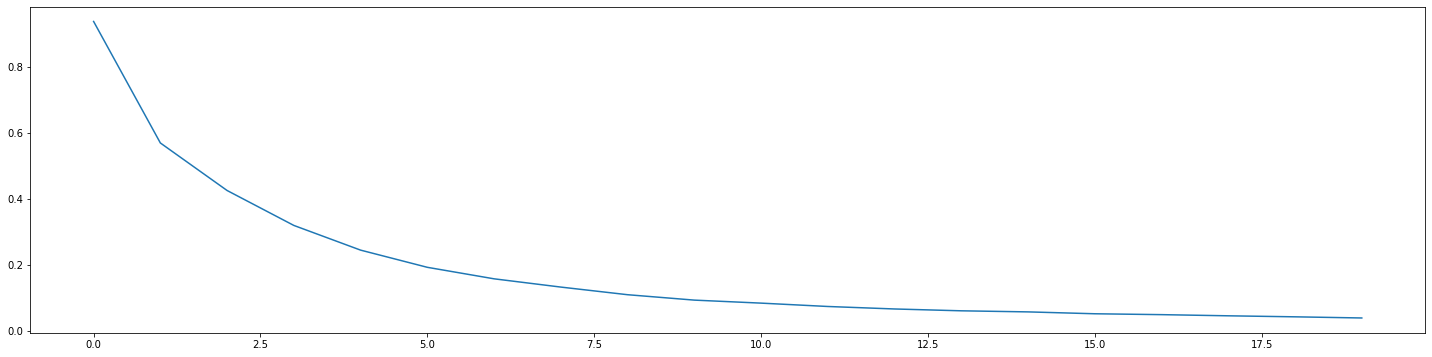

In [93]:
plt.plot(hist.history['loss'])

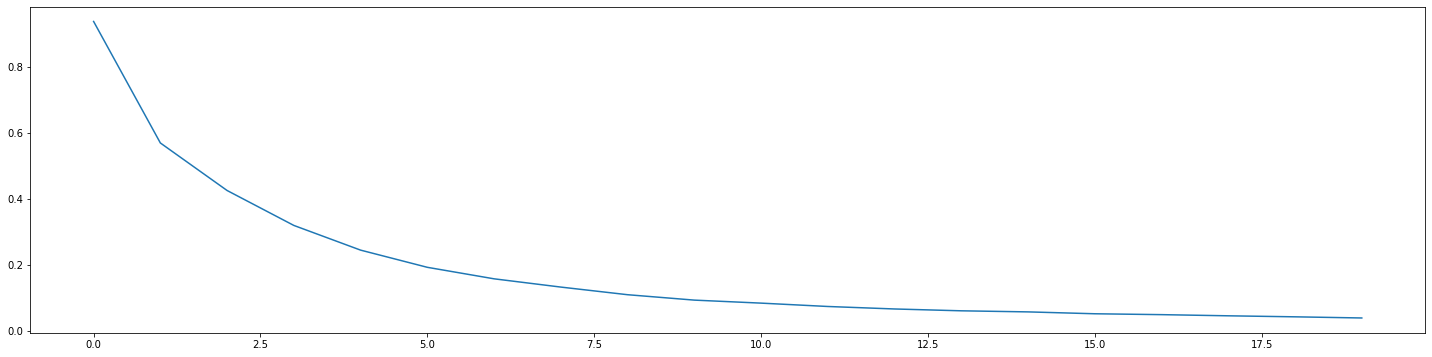

In [94]:
plt.plot(hist.history['MSE'])

In [95]:
predictions = model.predict(PCs_reshape)

85/85 [==============================] - 2s 16ms/step


In [96]:
predictions.shape

(2700, 12)

In [97]:
mean_diff_list = []
for i in range(12):
    mean_diff_list = np.nanmean(predictions[:,i]) - np.nanmean(d_Y_train[:,i])

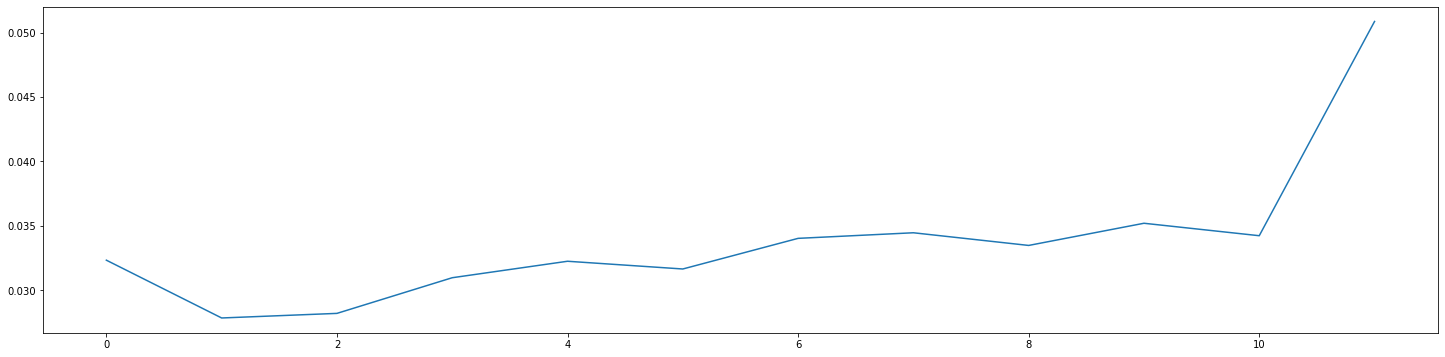

In [101]:
plt.plot(np.mean((predictions-d_Y_train)**2, axis=0))
plt.show()

In [106]:
predictions_test = model.predict(PCs_test_reshape)

10/10 [==============================] - 0s 13ms/step


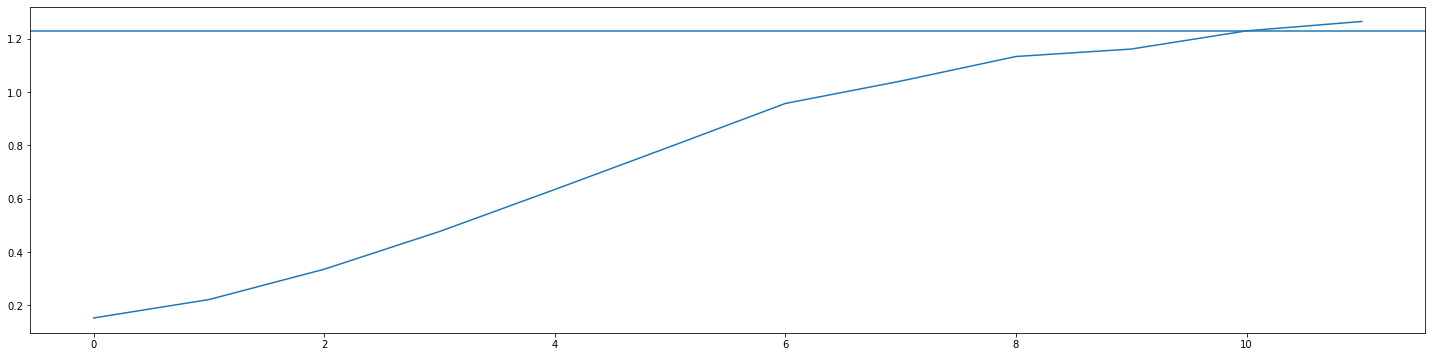

In [112]:
plt.plot(np.mean((predictions_test-d_Y_test)**2, axis=0))
plt.axhline(y = 1.2311253187254545)
plt.show()